In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\ACETOXYPHENANTHRYLMERCURY_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,ACETOXYPHENANTHRYLMERCURY
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,4.840
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,4.595


In [4]:
#drop the target drug response variable
drug = data.pop(data.columns[-1])

In [5]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [6]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [7]:
X.shape

(52, 197)

In [8]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [9]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [10]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    43
1     9
dtype: int64

In [11]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [12]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.840308,-0.042210,-0.645894,-0.851749,0.263794,-0.605549,0.435431,-0.433584,-0.387419,0.871082,...,-1.287424,-1.030917,-0.466780,-1.138819,1.041103,-1.236799,-0.564404,0.482249,-0.741883,1.534886
1,-0.247616,0.740683,-0.276074,-0.296686,0.889701,-0.342820,-1.049549,-1.073309,-1.122857,1.491898,...,-0.912414,-0.114667,-1.231704,-0.131730,-0.979706,-1.085557,-1.314730,-2.254493,-1.682773,1.130468


In [13]:
X.shape, y.shape

((86, 197), (86,))

In [14]:
y.value_counts()

0    43
1    43
dtype: int64

In [15]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
X_train.shape, X_test.shape

((68, 197), (18, 197))

In [17]:
y_train.value_counts(), y_test.value_counts()

(0    35
 1    33
 dtype: int64,
 1    10
 0     8
 dtype: int64)

In [18]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 67
Number of features selected during iteration 1: 59
Number of features selected during iteration 2: 64
Number of features selected during iteration 3: 65
Number of features selected during iteration 4: 64
Number of features selected during iteration 5: 67
Number of features selected during iteration 6: 61
Number of features selected during iteration 7: 62
Number of features selected during iteration 8: 59
Number of features selected during iteration 9: 59
Number of features selected during iteration 10: 61
Number of features selected during iteration 11: 62
Number of features selected during iteration 12: 68
Number of features selected during iteration 13: 73
Number of features selected during iteration 14: 67
Number of features selected during iteration 15: 59
Number of features selected during iteration 16: 61
Number of features selected during iteration 17: 65
Number of features selected during iteration 18: 69
Number of features sel

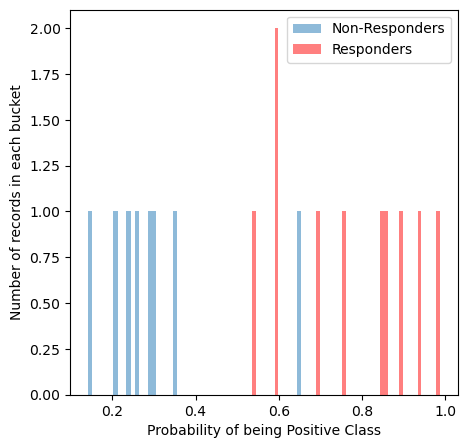

In [19]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [20]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.840308,-0.042210,-0.645894,-0.851749,0.263794,-0.605549,0.435431,-0.433584,-0.387419,0.871082,...,-0.466780,-1.138819,1.041103,-1.236799,-0.564404,0.482249,-0.741883,1.534886,0.141333,0.0
1,-0.247616,0.740683,-0.276074,-0.296686,0.889701,-0.342820,-1.049549,-1.073309,-1.122857,1.491898,...,-1.231704,-0.131730,-0.979706,-1.085557,-1.314730,-2.254493,-1.682773,1.130468,0.290000,0.0
2,1.220075,1.088032,-0.955808,-0.533262,0.826156,-0.711285,1.032978,0.787766,0.793652,-0.644424,...,-0.007108,-1.017045,-0.076660,-1.113477,-0.410521,-0.485137,-0.619340,0.093937,0.696267,1.0
3,-1.634504,-1.377805,1.127625,0.591373,1.504851,-0.508669,0.539488,1.861468,2.055061,-0.772520,...,-0.186014,-0.388537,0.476534,0.304541,-0.508523,-0.793075,0.620205,-0.542840,NaN,NaN
4,-1.663858,0.092439,-0.289934,0.133505,-1.419887,-0.707344,-0.691683,-0.136893,-0.511047,-0.929543,...,-1.323968,0.087030,-1.811860,1.298321,-2.318116,-0.612065,-1.171721,0.255920,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.986571,0.841385,-0.985441,-0.592898,0.778700,-0.731792,0.760121,0.623377,0.648572,-0.475573,...,-0.049395,-1.023169,-0.175354,-1.111214,-0.367306,-0.492619,-0.613985,-0.043489,NaN,NaN
82,-0.342376,-0.351537,-0.598613,-0.444189,0.370275,-0.601732,-0.228678,0.620917,0.660815,-0.065707,...,1.232210,0.442163,0.423105,-0.340885,0.517810,0.712355,0.925862,-0.181871,NaN,NaN
83,-0.414471,-0.237312,-0.454380,0.416823,0.245194,2.837546,-0.108429,0.429089,0.303756,0.728961,...,0.648822,0.773263,-0.179269,0.484170,0.796161,0.603431,0.531054,-0.534806,NaN,NaN
84,-0.067368,-1.394945,0.728387,1.914138,-0.629152,-0.610403,-0.409258,-0.950164,-0.828593,-0.287491,...,-0.208733,-0.942716,0.764027,0.178261,0.697340,-0.326235,-0.142708,-0.813245,NaN,NaN


In [21]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 199)

In [22]:
x

0.6538666666666668

In [23]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 69
Features selected during iteration 1: 66
Features selected during iteration 2: 59
Features selected during iteration 3: 73
Features selected during iteration 4: 65
Features selected during iteration 5: 61
Features selected during iteration 6: 66
Features selected during iteration 7: 66
Features selected during iteration 8: 64
Features selected during iteration 9: 61
Features selected during iteration 10: 64
Features selected during iteration 11: 69
Features selected during iteration 12: 64
Features selected during iteration 13: 57
Features selected during iteration 14: 61
Features selected during iteration 15: 61
Features selected during iteration 16: 67
Features selected during iteration 17: 64
Features selected during iteration 18: 62
Features selected during iteration 19: 68
Features selected during iteration 20: 63
Features selected during iteration 21: 67
Features selected during iteration 22: 66
Features selected during iteration 23: 63
Fe

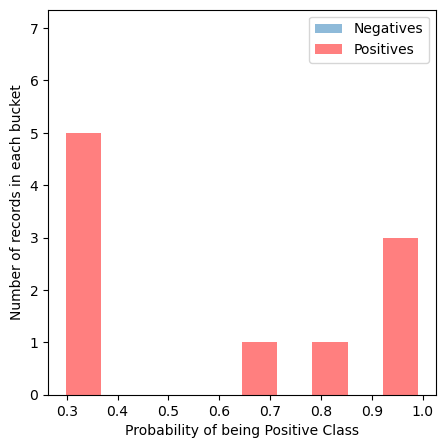

In [24]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [25]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [26]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
2,1.220075,1.088032,-0.955808,-0.533262,0.826156,-0.711285,1.032978,0.787766,0.793652,-0.644424,...,-0.007108,-1.017045,-0.076660,-1.113477,-0.410521,-0.485137,-0.619340,0.093937,0.833388,1.0
11,-0.165000,0.139494,1.870049,3.005235,-1.721261,2.291636,0.288972,-1.251609,-1.185988,-0.477249,...,-0.645115,0.222294,-0.882679,2.330426,0.077756,0.397959,0.170105,-1.455034,0.329184,1.0
15,-0.079492,-1.534747,0.843343,2.150305,-0.536817,-0.667618,-0.328266,-0.885519,-0.760264,-0.319801,...,-0.104922,-1.028350,0.907933,0.247607,0.894211,-0.197383,-0.020146,-0.831704,0.979967,1.0
37,0.057517,0.045071,-0.455710,-0.518467,-1.580247,-0.021062,-1.243500,-1.616030,-1.532414,0.045314,...,-1.278021,-0.060661,-0.718255,-0.536035,-1.330508,-1.653462,-1.405138,-0.623114,0.317395,1.0
45,-0.778778,0.192780,-0.494843,-0.859687,-0.348316,-0.686789,-0.593402,-0.343857,-0.238678,0.192258,...,-0.305427,-1.047985,-0.365605,-1.434272,-0.907056,-0.060503,-0.672399,0.006781,0.298045,1.0


In [27]:
max(prediction2[y_test == 0])

0.29804468932231765

In [28]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 29
Features selected during iteration 1: 29
Features selected during iteration 2: 29
Features selected during iteration 3: 29
Features selected during iteration 4: 29
Features selected during iteration 5: 29
Features selected during iteration 6: 29
Features selected during iteration 7: 29
Features selected during iteration 8: 29
Features selected during iteration 9: 29
Features selected during iteration 10: 29
Features selected during iteration 11: 29
Features selected during iteration 12: 29
Features selected during iteration 13: 29
Features selected during iteration 14: 29
Features selected during iteration 15: 29
Features selected during iteration 16: 29
Features selected during iteration 17: 29
Features selected during iteration 18: 29
Features selected during iteration 19: 29
Features selected during iteration 20: 29
Features selected during iteration 21: 29
Features selected during iteration 22: 29
Features selected during iteration 23: 29
Fe

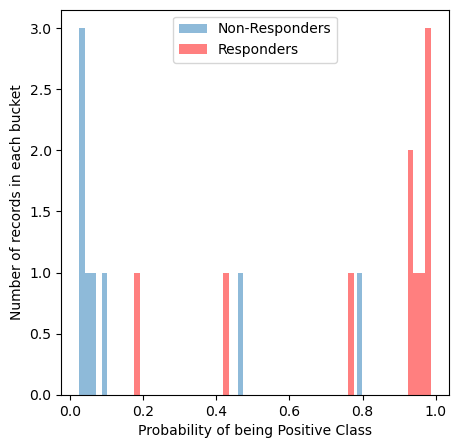

In [29]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [30]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.840308,-0.042210,-0.645894,-0.851749,0.263794,-0.605549,0.435431,-0.433584,-0.387419,0.871082,...,-0.466780,-1.138819,1.041103,-1.236799,-0.564404,0.482249,-0.741883,1.534886,0.043579,0.0
1,-0.247616,0.740683,-0.276074,-0.296686,0.889701,-0.342820,-1.049549,-1.073309,-1.122857,1.491898,...,-1.231704,-0.131730,-0.979706,-1.085557,-1.314730,-2.254493,-1.682773,1.130468,0.036467,0.0
2,1.220075,1.088032,-0.955808,-0.533262,0.826156,-0.711285,1.032978,0.787766,0.793652,-0.644424,...,-0.007108,-1.017045,-0.076660,-1.113477,-0.410521,-0.485137,-0.619340,0.093937,0.426552,1.0
3,-1.634504,-1.377805,1.127625,0.591373,1.504851,-0.508669,0.539488,1.861468,2.055061,-0.772520,...,-0.186014,-0.388537,0.476534,0.304541,-0.508523,-0.793075,0.620205,-0.542840,NaN,NaN
4,-1.663858,0.092439,-0.289934,0.133505,-1.419887,-0.707344,-0.691683,-0.136893,-0.511047,-0.929543,...,-1.323968,0.087030,-1.811860,1.298321,-2.318116,-0.612065,-1.171721,0.255920,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.986571,0.841385,-0.985441,-0.592898,0.778700,-0.731792,0.760121,0.623377,0.648572,-0.475573,...,-0.049395,-1.023169,-0.175354,-1.111214,-0.367306,-0.492619,-0.613985,-0.043489,NaN,NaN
82,-0.342376,-0.351537,-0.598613,-0.444189,0.370275,-0.601732,-0.228678,0.620917,0.660815,-0.065707,...,1.232210,0.442163,0.423105,-0.340885,0.517810,0.712355,0.925862,-0.181871,NaN,NaN
83,-0.414471,-0.237312,-0.454380,0.416823,0.245194,2.837546,-0.108429,0.429089,0.303756,0.728961,...,0.648822,0.773263,-0.179269,0.484170,0.796161,0.603431,0.531054,-0.534806,NaN,NaN
84,-0.067368,-1.394945,0.728387,1.914138,-0.629152,-0.610403,-0.409258,-0.950164,-0.828593,-0.287491,...,-0.208733,-0.942716,0.764027,0.178261,0.697340,-0.326235,-0.142708,-0.813245,NaN,NaN


In [31]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
11,-0.165000,0.139494,1.870049,3.005235,-1.721261,2.291636,0.288972,-1.251609,-1.185988,-0.477249,...,-0.645115,0.222294,-0.882679,2.330426,0.077756,0.397959,0.170105,-1.455034,0.960266,1.0
15,-0.079492,-1.534747,0.843343,2.150305,-0.536817,-0.667618,-0.328266,-0.885519,-0.760264,-0.319801,...,-0.104922,-1.028350,0.907933,0.247607,0.894211,-0.197383,-0.020146,-0.831704,0.955135,1.0


In [32]:
max(prediction3[y_test == 0])

0.79943347

In [33]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [34]:
cl = set(common_list)
cl

{2, 11, 15, 37, 45}

In [35]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
2,1.220075,1.088032,-0.955808,-0.533262,0.826156,-0.711285,1.032978,0.787766,0.793652,-0.644424,...,-0.007108,-1.017045,-0.076660,-1.113477,-0.410521,-0.485137,-0.619340,0.093937,0.696267,1.0
11,-0.165000,0.139494,1.870049,3.005235,-1.721261,2.291636,0.288972,-1.251609,-1.185988,-0.477249,...,-0.645115,0.222294,-0.882679,2.330426,0.077756,0.397959,0.170105,-1.455034,0.760933,1.0
15,-0.079492,-1.534747,0.843343,2.150305,-0.536817,-0.667618,-0.328266,-0.885519,-0.760264,-0.319801,...,-0.104922,-1.028350,0.907933,0.247607,0.894211,-0.197383,-0.020146,-0.831704,0.859067,1.0
37,0.057517,0.045071,-0.455710,-0.518467,-1.580247,-0.021062,-1.243500,-1.616030,-1.532414,0.045314,...,-1.278021,-0.060661,-0.718255,-0.536035,-1.330508,-1.653462,-1.405138,-0.623114,0.536000,1.0
45,-0.778778,0.192780,-0.494843,-0.859687,-0.348316,-0.686789,-0.593402,-0.343857,-0.238678,0.192258,...,-0.305427,-1.047985,-0.365605,-1.434272,-0.907056,-0.060503,-0.672399,0.006781,0.592667,1.0


In [36]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [37]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')